In [105]:
import numpy as np 
import pandas as pd 
import re
import pickle 
from itertools import chain
from datetime import datetime
from collections import defaultdict

from typing import List, Dict, Optional, Iterable, Tuple

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import string


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/russian-jokes/jokes.csv
/kaggle/input/vk-anekdots/anekdots_result.csv


In [ ]:
class Tokenizer:
    def __init__(self,
                 token_pattern: str = '\w+|[\!\?\,\.\-\:]',
                 eos_token: str = '<EOS>',
                 pad_token: str = '<PAD>',
                 unk_token: str = '<UNK>'):
        self.token_pattern = token_pattern
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.unk_token = unk_token
        
        self.special_tokens = [self.eos_token, self.pad_token, self.unk_token]
        self.vocab = None
        self.inverse_vocab = None
    
    def text_preprocess(self, input_text: str) -> str:
        """ Предобрабатываем один текст """
        input_text = input_text.lower()
        input_text = re.sub(r'\s+', ' ', input_text) 
        input_text = input_text.strip()
        return input_text
    
    def build_vocab(self, corpus: List[str]) -> None:
        assert len(corpus)
        all_tokens = set()
        for text in corpus:
            all_tokens |= set(self._tokenize(text, append_eos_token=False))
        self.vocab = {elem: ind for ind, elem in enumerate(all_tokens)}
        special_tokens = [self.eos_token, self.unk_token, self.pad_token]
        for token in special_tokens:
            self.vocab[token] = len(self.vocab)
        self.inverse_vocab = {ind: elem for elem, ind in self.vocab.items()}
        return self
        
    def _tokenize(self, text: str, append_eos_token: bool = True) -> List[str]:
        text = self.text_preprocess(text)
        tokens = re.findall(self.token_pattern, text)
        if append_eos_token:
            tokens.append(self.eos_token)
        return tokens
    
    def encode(self, text: str, append_eos_token: bool = True) -> List[str]:
        """ Токенизируем текст """
        tokens = self._tokenize(text, append_eos_token)
        ids = [self.vocab.get(token, self.vocab[self.unk_token]) for token in tokens]
        return ids
    
    def decode(self, input_ids: Iterable[int], remove_special_tokens: bool = False) -> str:
        assert len(input_ids)
        assert max(input_ids) < len(self.vocab) and min(input_ids) >= 0
        tokens = []
        for ind in input_ids:
            token = self.inverse_vocab[ind]
            if remove_special_tokens and token in self.special_tokens:
                continue
            tokens.append(token)
        text = ' '.join( tokens )
        return text
    
    def save(self, path: str) -> bool:
        data = {
            'token_pattern': self.token_pattern,
            'eos_token': self.eos_token,
            'pad_token': self.pad_token,
            'unk_token': self.unk_token,
            'special_tokens': self.special_tokens,
            'vocab': self.vocab,
            'inverse_vocab': self.inverse_vocab,
        }
        
        with open(path, 'wb') as fout:
            pickle.dump(data, fout)
            
        return True
        
    def load(self, path: str) -> bool:
        with open(path, 'rb') as fin:
            data = pickle.load(fin)
            
        self.token_pattern = data['token_pattern']
        self.eos_token = data['eos_token']
        self.pad_token = data['pad_token']
        self.unk_token = data['unk_token']
        self.special_tokens = data['special_tokens']
        self.vocab = data['vocab']
        self.inverse_vocab = data['inverse_vocab']


In [88]:
class GenerationConfig:
    def __init__(self, **kwargs):
        """
        Тут можно задать любые параметры и их значения по умолчанию
        Значения для стратегии декодирования decoding_strategy: ['max', 'top-p']
        """
        self.temperature = kwargs.pop("temperature", 1.0)
        self.max_tokens = kwargs.pop("max_tokens", 32)
        self.sample_top_p = kwargs.pop("sample_top_p", 0.9)
        self.decoding_strategy = kwargs.pop("decoding_strategy", 'max')
        self.remove_special_tokens = kwargs.pop("remove_special_tokens", False)
        self.validate()
        
    def validate(self):
        """ Здесь можно валидировать параметры """
        if not (1.0 > self.sample_top_p > 0):
            raise ValueError('sample_top_p')
        if self.decoding_strategy not in ['max', 'top-p']:
            raise ValueError('decoding_strategy')

In [ ]:
class StatLM:
    def __init__(self, 
                 tokenizer: Tokenizer,
                 context_size: int = 2,
                 alpha: float = 0.1
                ):
        
        assert context_size >= 2
        
        self.context_size = context_size
        self.tokenizer = tokenizer
        self.alpha = alpha
        
        self.n_gramms_stat = defaultdict(int)
        self.nx_gramms_stat = defaultdict(int)
        
    def get_token_by_ind(ind: int) -> str:
        return self.tokenizer.vocab.get(ind)
    
    def get_ind_by_token(token: str) -> int:
        return self.tokenizer.inverse_vocab.get(token, self.tokenizer.inverse_vocab[self.unk_token])
        
    def train(self, train_texts: List[str]):
        for sentence in tqdm(train_texts, desc='train lines'):
            sentence_ind = self.tokenizer.encode(sentence)
            for i in range(len(sentence_ind) - self.context_size):
                
                seq = tuple(sentence_ind[i: i + self.context_size - 1])
                self.n_gramms_stat[seq] += 1
                
                seq_x = tuple(sentence_ind[i: i + self.context_size])
                self.nx_gramms_stat[seq_x] += 1
                
            seq = tuple(sentence_ind[len(sentence_ind) - self.context_size:])
            self.n_gramms_stat[seq] += 1
            
    def sample_token(self, 
                     token_distribution: np.ndarray,
                     generation_config: GenerationConfig) -> int:
        if generation_config.decoding_strategy == 'max':
            return token_distribution.argmax()
        elif generation_config.decoding_strategy == 'top-p':
            token_distribution = sorted(list(zip(token_distribution, np.arange(len(token_distribution)))),
                                        reverse=True)
            total_proba = 0.0
            tokens_to_sample = []
            tokens_probas = []
            for token_proba, ind in token_distribution:
                tokens_to_sample.append(ind)
                tokens_probas.append(token_proba)
                total_proba += token_proba
                if total_proba >= generation_config.sample_top_p:
                    break

            tokens_probas = np.array(tokens_probas) / generation_config.temperature
            tokens_probas = tokens_probas / tokens_probas.sum()
            return np.random.choice(tokens_to_sample, p=tokens_probas)
        else:
            raise ValueError(f'Unknown decoding strategy: {generation_config.decoding_strategy}')
            
    def save_stat(self, path: str) -> bool:
        stat = {
            'n_gramms_stat': self.n_gramms_stat,
            'nx_gramms_stat': self.nx_gramms_stat,
            'context_size': self.context_size,
            'alpha': self.alpha
        }
        with open(path, 'wb') as fout:
            pickle.dump(stat, fout)
            
        return True
    
    def load_stat(self, path: str) -> bool:
        with open(path, 'rb') as fin:
            stat = pickle.load(fin)
            
        self.n_gramms_stat = stat['n_gramms_stat']
        self.nx_gramms_stat = stat['nx_gramms_stat']
        self.context_size = stat['context_size']
        self.alpha = stat['alpha']
            
        return True
        
    def get_stat(self) -> Dict[str, Dict]:
        
        n_token_stat, nx_token_stat = {}, {}
        for token_inds, count in self.n_gramms_stat.items():
            n_token_stat[self.tokenizer.decode(token_inds)] = count
        
        for token_inds, count in self.nx_gramms_stat.items():
            nx_token_stat[self.tokenizer.decode(token_inds)] = count
        
        return {
            'n gramms stat': self.n_gramms_stat,
            'n+1 gramms stat': self.nx_gramms_stat,
            'n tokens stat': n_token_stat,
            'n+1 tokens stat': nx_token_stat,
        }
    
    def _get_next_token(self, 
                        tokens: List[int],
                        generation_config: GenerationConfig) -> (int, str):
        denominator = self.n_gramms_stat.get(tuple(tokens), 0) + self.alpha * len(self.tokenizer.vocab)
        numerators = []
        for ind in self.tokenizer.inverse_vocab:
            numerators.append(self.nx_gramms_stat.get(tuple(tokens + [ind]), 0) + self.alpha)
        
        token_distribution = np.array(numerators) / denominator
        max_proba_ind = self.sample_token(token_distribution, generation_config)
        
        next_token = self.tokenizer.inverse_vocab[max_proba_ind]
        
        return max_proba_ind, next_token
            
    def generate_token(self, 
                       text: str, 
                       generation_config: GenerationConfig
                      ) -> Dict:
        tokens = self.tokenizer.encode(text, append_eos_token=False)
        tokens = tokens[-self.context_size + 1:]
        
        max_proba_ind, next_token = self._get_next_token(tokens, generation_config)
        
        return {
            'next_token': next_token,
            'next_token_num': max_proba_ind,
        }
    
    
    def generate_text(self, text: str, 
                      generation_config: GenerationConfig
                     ) -> Dict:
        
        all_tokens = self.tokenizer.encode(text, append_eos_token=False)
        tokens = all_tokens[-self.context_size + 1:]
        
        next_token = None
        while next_token != self.tokenizer.eos_token and len(all_tokens) < generation_config.max_tokens:
            max_proba_ind, next_token = self._get_next_token(tokens, generation_config)
            all_tokens.append(max_proba_ind)
            tokens = all_tokens[-self.context_size + 1:]
        
        new_text = self.tokenizer.decode(all_tokens, generation_config.remove_special_tokens)
        
        finish_reason = 'max tokens'
        if all_tokens[-1] == self.tokenizer.vocab[self.tokenizer.eos_token]:
            finish_reason = 'end of text'
        
        return {
            'all_tokens': all_tokens,
            'total_text': new_text,
            'finish_reason': finish_reason
        }
    
    def generate(self, text: str, generation_config: Dict) -> str:
        return self.generate_text(text, generation_config)['total_text']

In [90]:
texts = pd.read_csv('../input/russian-jokes/jokes.csv')['text']
len(texts)

130204

In [91]:
added_texts = pd.read_csv('../input/vk-anekdots/anekdots_result.csv')['text']
len(added_texts)

233683

In [108]:
data = pd.concat([texts, added_texts], axis=0).reset_index().drop('index', axis=1)
data

,text
0,На суде в Стамбуле обвиняемый сказал:\r\n- На...
1,"- Вы продолжаете утверждать, что обвиняемый н..."
2,"На суде.\r\n- Итак, когда дело дошло до столкн..."
3,Старую леди сбил автомобиль. На суде ее спраши...
4,"Судья говорит:\r\n- Согласно вашей жалобе, об..."
...,...
363882,"Это абсолютно реальная история, которую расска..."
363883,В один престижный бутик заходит блондинистая к...
363884,Маршрутка. Заходит бабулька божий одуванчик. П...
363885,И чего только пьяному человеку в голову не при...


In [109]:
str_lenghts = data['text'].str.len()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


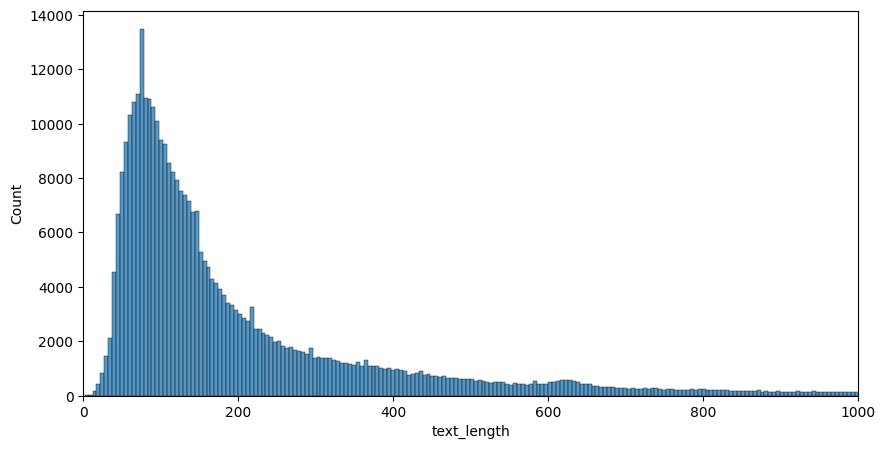

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim(0, 1000)
ax.set_xlabel('text_length')
sns.histplot(str_lenghts, ax=ax)
plt.show()

In [111]:
q = str_lenghts.quantile(q=0.9)
q

550.0

In [112]:
small_indexes = (str_lenghts <= q)

In [113]:
data = data[small_indexes]
data = data.reset_index(drop=True)
len(data)

327580

In [114]:
unique_ind = data['text'].apply(lambda x: re.sub(r'[^а-яА-Я0-9]', '', x.lower())).drop_duplicates().index.values

In [115]:
data = data.iloc[unique_ind]
data = data.reset_index(drop=True)
data

,text
0,На суде в Стамбуле обвиняемый сказал:\r\n- На...
1,"- Вы продолжаете утверждать, что обвиняемый н..."
2,"На суде.\r\n- Итак, когда дело дошло до столкн..."
3,Старую леди сбил автомобиль. На суде ее спраши...
4,"Судья говорит:\r\n- Согласно вашей жалобе, об..."
...,...
321525,"Позвонил друг, поделился восторгом.\nОн себе с..."
321526,Реальное объявление в мастерской по ремонту об...
321527,Не так давно предлагаю ребёнку отгадать извест...
321528,"Лежим с женой в спальне, смотрим романтическую..."


In [117]:
data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
data['text'] = data['text'].apply(lambda x: ' '.join(x.split()))

In [119]:
data['text'] = data['text'].apply(lambda x: re.sub(r'[^а-яА-Я0-9 -]', '', x.replace(',', ' ').lower()))

In [127]:
data['text'].head(10)

0    на суде в стамбуле обвиняемыи сказал на свои ж...
1    вы продолжаете утверждать что обвиняемыи назва...
2    на суде итак когда дело дошло до столкновения ...
3    старую леди сбил автомобиль на суде ее спрашив...
4    судья говорит согласно вашеи жалобе обвиняемыи...
5    на судебном заседании гражданка дроздова мы ра...
6    драка происходила так однои рукои я схватил ег...
7    судья свидетель вы должны говорить правду одну...
8    судья подсудимому ну ну перестаньте волноватьс...
9    судья спрашивает четырех индеи цев убежавших и...
Name: text, dtype: object

In [128]:
generation_config = GenerationConfig(temperature = 1.0, max_tokens = 16,
                                     sample_top_p = 0.1, decoding_strategy = 'top-p',
                                     remove_special_tokens=True)

In [129]:
tokenizer = Tokenizer().build_vocab(data['text'])

In [166]:
stat_lm = StatLM(tokenizer, context_size=3, alpha=0.001)
stat_lm.train(data['text'])

train lines:   0%|          | 0/321530 [00:00<?, ?it/s]

In [150]:
test_data = [
    'встретились как-то русский и американец',
    'сидит штирлиц в засаде',
    'приехала как-то теща в гости',
    'говорит чебурашка гене',
    'что общего между евреем и'
]

In [151]:
for i, test in enumerate(test_data):
    ans = stat_lm.generate(test, generation_config)
    print(f'q{i}: {ans}')

q0: встретились как то русский и американец попали в ад а черти то чем я могу
q1: сидит штирлиц в засаде на лыжне типун протеряешь пнешь вовочкинои шлифуем продвинутых потрохами заструился пргер изучающая
q2: приехала как то теща в гости к своему другу в гости к своему другу в
q3: говорит чебурашка гене ген а ген а ген а ген а ген а ген а ген
q4: что общего между евреем и неглупым человеком а этот лексус уже был помятый и кот это


In [152]:
generation_config = GenerationConfig(temperature = 0.1, max_tokens = 16,
                                     sample_top_p = 0.1, decoding_strategy = 'top-p',
                                     remove_special_tokens=True)

In [153]:
for i, test in enumerate(test_data):
    ans = stat_lm.generate(test, generation_config)
    print(f'q{i}: {ans}')

q0: встретились как то русский и американец американец спокойствие регэкспов полста вилли мыв посодють прибрана больны
q1: сидит штирлиц в засаде сидел глобусы обеспеченнои многоэтажка кланая сестрнки выугали радикальное правообладателя вступаешь медным шестеренка
q2: приехала как то теща в гости к другу и вместо баллончика тютелька природноочаговое возводим форматироваться
q3: говорит чебурашка гене выныривая секретнаая миля тождественныи виникають приятнве напасусь душевными прокаченныи гликозид проешь пашне применяться
q4: что общего между евреем и засосет учинил рекордсменке слабовато разрываем куто ладанка стаости четвэрг лечебном выделишь


In [155]:
generation_config = GenerationConfig(temperature = 0.1, max_tokens = 16,
                                     sample_top_p = 0.05, decoding_strategy = 'top-p',
                                     remove_special_tokens=True)

In [156]:
for i, test in enumerate(test_data):
    ans = stat_lm.generate(test, generation_config)
    print(f'q{i}: {ans}')

q0: встретились как то русский и американец попали в яму волк лиса мрачнеет кешью глобального индеец
q1: сидит штирлиц в засаде на вовочкиным гороскопы благодушно блузке выкройки приспичело волейбол катящийся безвыходности пристойный эстонская
q2: приехала как то теща в гости к своему другу вдруг семилетнего детныша охраняемый арнольдович даю
q3: говорит чебурашка гене вова послов прохлопала непреклоныи актриса посочувствуют уверяла смэтана компьютерном наполняю разрывающий элитная елдастиш
q4: что общего между евреем и армянином впасть венгерском шпилит мерзлота оккупации товарищампострадавшего 92 нокаутом потделок моряки


In [158]:
generation_config = GenerationConfig(temperature = 0.1, max_tokens = 16,
                                     sample_top_p = 0.01, decoding_strategy = 'top-p',
                                     remove_special_tokens=True)

In [159]:
for i, test in enumerate(test_data):
    ans = stat_lm.generate(test, generation_config)
    print(f'q{i}: {ans}')

q0: встретились как то русский и американец попали в ад а черти то бедные бешеные привязанным
q1: сидит штирлиц в засаде на лыжне олимп глубинная шабл сказавший молотком4 допиздишься загоню изврашенец благодушно кирпич
q2: приехала как то теща в гости к своему другу в гости к своему другу в
q3: говорит чебурашка гене ген а ген а ген а ген а ген а ген а ген
q4: что общего между евреем и проживающем голосит неприятности элвису фурия ухмылялось кодовым неимущим подслушанныи ангелочки монсерат


In [161]:
generation_config = GenerationConfig(temperature = 1, max_tokens = 16,
                                     sample_top_p = 0.01, decoding_strategy = 'top-p',
                                     remove_special_tokens=True)

In [162]:
for i, test in enumerate(test_data):
    ans = stat_lm.generate(test, generation_config)
    print(f'q{i}: {ans}')

q0: встретились как то русский и американец попали в ад а черти в котел ее а
q1: сидит штирлиц в засаде на углу улицы стоит нищий с хуические хиба долговременное разошлась табачному пилять
q2: приехала как то теща в гости к своему другу в гости к своему другу в
q3: говорит чебурашка гене а даваи те я вам не стыдно вы сорок лет водил моисей евреев
q4: что общего между евреем и неглупым крепкости бодрит шагов поговорит прижатой амеиканская паи полисмена дуреют рно


In [179]:
generation_config = GenerationConfig(temperature = 2, max_tokens = 16,
                                     sample_top_p = 0.012, decoding_strategy = 'top-p',
                                     remove_special_tokens=True)

In [180]:
for i, test in enumerate(test_data):
    ans = stat_lm.generate(test, generation_config)
    print(f'q{i}: {ans}')

q0: встретились как то русский и американец попали в ад а черти то бедные в рекрутеры
q1: сидит штирлиц в засаде на проспекте гагарина такая намордника накидаться неимущим групповухой исчезнете ваааах перебрала кормильцу
q2: приехала как то теща в гости к своему другу в гости к своему другу в
q3: говорит чебурашка гене а даваи те я вам не стыдно вы сорок лет водил моисей евреев
q4: что общего между евреем и неглупым человеком а этот лексус уже был помятый и кот это


In [218]:
generation_config = GenerationConfig(temperature = 2.1, max_tokens = 16,
                                     sample_top_p = 0.0129, decoding_strategy = 'top-p',
                                     remove_special_tokens=True)

In [219]:
for i, test in enumerate(test_data):
    ans = stat_lm.generate(test, generation_config)
    print(f'q{i}: {ans}')

q0: встретились как то русский и американец попали в ад а черти то бедные в холодильнике
q1: сидит штирлиц в засаде на углу улицы стоит нищий сапожков скромничаи расшарил красавцев гейшей доме плоскостопсть
q2: приехала как то теща в гости к своему другу в гости к своему другу в
q3: говорит чебурашка гене гена гена шапокляк родила что листков стынут терма бриалиантами разморозив потустронних клейковина можется
q4: что общего между евреем и неглупым человеком абмоба зарубим хвастайся поклажей таблетку комдессю бухаешь онколога петросянизма


In [221]:
tokenizer.save('tokenizer.pkl')
stat_lm.save_stat('stat_lm.pkl')

True